<a href="https://colab.research.google.com/github/aptronz/Projects/blob/main/Facial_Expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-r12icf0y
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-r12icf0y
  Resolved https://github.com/albumentations-team/albumentations to commit 497ab56463b9721a308a08536d846aed86f40e0b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [47]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDDER_PATH = '/content/Facial-Expression-Dataset/validation'
LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15
DEVICE='cuda'
MODEL_NAME = 'efficient_b0'

In [48]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [49]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor()#PIL/ numpy arr-> torch tensor

])
valid_augs = T.Compose([
    T.ToTensor()
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [50]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDDER_PATH, transform = valid_augs)

In [51]:
print(f"Total no. of batches in trainset : {len(trainset)}")
print(f"Total no. of batches in validset : {len(validset)}")

Total no. of batches in trainset : 28821
Total no. of batches in validset : 7066


In [52]:
print (trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '3')

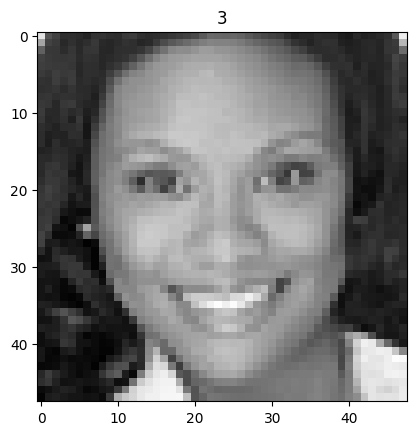

In [53]:
image, label= validset[3000]

plt.imshow(image.permute(1, 2, 0))
plt.title(label)

In [54]:
from torch.utils.data import DataLoader

In [55]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [56]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [57]:
for images, labels in trainloader:
  break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


In [58]:
import timm
from torch import nn

In [59]:
class Facemodel(nn.Module):
    def __init__(self):
        super(Facemodel, self).__init__() # Properly call super().__init__()
        self.eff_net = timm.create_model('efficientnet_b0', pretrained=True, num_classes=7) # Use 'efficientnet_b0'
    def forward(self, images, labels=None):
        logits = self.eff_net(images)
        if labels is not None: # Use 'is not None' instead of '!=' for None comparison
            loss = nn.CrossEntropyLoss()(logits, labels)
            return loss, logits
        return logits

In [60]:
model = Facemodel()
model.to(DEVICE);

In [61]:
from tqdm import tqdm

In [67]:
def multiclass_accuracy(y_pred, y_true):
    top_p, top_class= y_pred.topk(1,dim=1)
    equals= top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [68]:
def train_fn(model,dataloader, optimizer, current_epo):
  model.train()
  total_loss=0.0
  total_acc= 0.0
  tk= tqdm(dataloader, desc="EPOCH"+"[TRAIN]"+ str(current_epo +1)+"/"+ str(EPOCHS))
  for t,data in enumerate(tk):
    images,labels=data
    images,labels=images.to(DEVICE),labels.to(DEVICE)

    optimizer.zero_grad()
    loss, logits= model(images,labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss/(t+1)),'acc' : '%6f' %float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc/len(dataloader)



In [69]:
def eval_fn(model,dataloader, current_epo):
  model.eval()
  total_loss=0.0
  total_acc= 0.0
  tk= tqdm(dataloader, desc="EPOCH"+"[VALID]"+ str(current_epo +1)+"/"+ str(EPOCHS))
  for t,data in enumerate(tk):
    images,labels=data
    images,labels=images.to(DEVICE),labels.to(DEVICE)

    loss, logits= model(images,labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss/(t+1)),'acc' : '%6f' %float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc/len(dataloader)

In [70]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [71]:
best_valid_loss= np.Inf
for i in range(EPOCHS):
  train_loss, train_acc= train_fn(model, trainloader,optimizer,i)
  valid_loss, valid_acc = eval_fn(model, validloader,i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('SAVED-BEST-WEIGHTS')
    best_valid_loss = valid_loss



EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:09<00:00, 23.13it/s, loss=1.326523, acc=0.498945]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:06<00:00, 34.05it/s, loss=1.193948, acc=0.548338]


SAVED-BEST-WEIGHTS


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:06<00:00, 35.45it/s, loss=1.134165, acc=0.572007]


SAVED-BEST-WEIGHTS


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:05<00:00, 36.86it/s, loss=1.090479, acc=0.592042]


SAVED-BEST-WEIGHTS


EPOCH[VALID]6/15: 100%|██████████| 221/221 [00:05<00:00, 37.59it/s, loss=1.057050, acc=0.604355]


SAVED-BEST-WEIGHTS


EPOCH[VALID]7/15: 100%|██████████| 221/221 [00:06<00:00, 34.17it/s, loss=1.029543, acc=0.615472]


SAVED-BEST-WEIGHTS


EPOCH[VALID]9/15: 100%|██████████| 221/221 [00:06<00:00, 35.71it/s, loss=1.025835, acc=0.616864]


SAVED-BEST-WEIGHTS


EPOCH[VALID]10/15: 100%|██████████| 221/221 [00:06<00:00, 33.98it/s, loss=1.013137, acc=0.627012]


SAVED-BEST-WEIGHTS


EPOCH[VALID]13/15: 100%|██████████| 221/221 [00:06<00:00, 36.72it/s, loss=0.987092, acc=0.635670]


SAVED-BEST-WEIGHTS


EPOCH[VALID]14/15: 100%|██████████| 221/221 [00:06<00:00, 33.71it/s, loss=0.970987, acc=0.651921]


SAVED-BEST-WEIGHTS


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:06<00:00, 35.59it/s, loss=0.980482, acc=0.644568]


In [72]:

def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None